# Simulating Relax displacements with a basal dislocation

In [1]:
import xarray as xa

# Define simulation name
sh_name = 'dip20_z2.0_eta0.2.sh'
directory = f"./parameter_ranges/output_{sh_name[:-3]}".format()

# Load in a single displacement result to define the grid
pathname = directory + "/000-east.grd"
grid = xa.load_dataarray(pathname)

## Set up triangular dislocation sources

In [2]:
def tri_horizon(x, y, z, el_size):
    # Makes a simple ~horizon of triangular dislocation elements using Gmsh
    # x, y are 2-element arrays defining horizontal bounds
    # z is a scalar giving depth 
    # el_size gives nominal element size 

    import gmsh
    import meshio
    
    # Mesh construction using Gmsh
    gmsh.initialize()
    # Define points
    gmsh.model.geo.addPoint(x[0], y[0], z+0.01, el_size, 1)
    gmsh.model.geo.addPoint(x[1], y[0], z-0.01, el_size, 2)
    gmsh.model.geo.addPoint(x[1], y[1], z-0.01, el_size, 3)
    gmsh.model.geo.addPoint(x[0], y[1], z+0.01, el_size, 4)
    # Boundary lines
    gmsh.model.geo.addLine(1, 2, 1)
    gmsh.model.geo.addLine(2, 3, 2)
    gmsh.model.geo.addLine(3, 4, 3)
    gmsh.model.geo.addLine(4, 1, 4)
    # Perimeter
    gmsh.model.geo.addCurveLoop([1, 2, 3, 4], 1)
    # Surface
    gmsh.model.geo.addPlaneSurface([1], 1)
    gmsh.model.geo.synchronize()
    # Generate and write. Writing a file allows use of meshio, consistent with celeri codes
    gmsh.model.mesh.generate(2)
    gmsh.write("file.msh")
    gmsh.finalize()

    # Read and parse mesh
    mesh = meshio.read("file.msh")
    fault_pts = mesh.points
    fault_tri = meshio.CellBlock("triangle", mesh.get_cells_type("triangle")).data
    return fault_pts, fault_tri

## Define source mesh and horizon, calculate partials

In [3]:
import cutde.halfspace as cutde_halfspace
import numpy as np
import pandas as pd
import addict
import celeri
import linecache

# Get stations from grid plotted above
gsubset = 10 # Subset of grid points: increment every gsubset points along grid
xg = np.array(grid.x)
yg = np.array(grid.y)
Xg, Yg = np.meshgrid(xg, yg)
obsg_full = np.array([Xg, Yg, 0*Yg]).reshape((3, -1)).T.copy()
grid_dim = np.shape(grid)[0]
# Identify row and column indices of grid subset
ri, ci = np.meshgrid(np.arange(0, grid_dim, gsubset), np.arange(0, grid_dim, gsubset))
# Convert to linear index
li = ri*grid_dim + ci
li = li.T.reshape((-1,))
# Create the grid subset
obsg = obsg_full[li, :]

# Read key information from Relax script: interface depth and fault geometry 
depthline = linecache.getline('./parameter_ranges/' + sh_name, 78)
depthstring = depthline.split()
hdepth = float(depthstring[1])

foff = 1.e-6 # Small coordinate offset, to avoid fault nodes coincident with observation grid
faultline = linecache.getline('./parameter_ranges/' + sh_name, 95)
faultstring = faultline.split()
fy0 = float(faultstring[2])
fx0 = float(faultstring[3]) + foff
fz0 = float(faultstring[4])
fleng = float(faultstring[5])
fwidth = float(faultstring[6])
fstrike = float(faultstring[7])
fdip = float(faultstring[8])*np.pi/180

# Define source fault
meshes = []
meshes.append(addict.Dict())

# Fault coordinates
meshes[0].coords = np.array([[fx0, fy0, fz0], [fx0+fwidth*np.cos(fdip), fy0, -fwidth*np.sin(fdip)], [fx0+fwidth*np.cos(fdip), fy0+fleng, -fwidth*np.sin(fdip)], [fx0, fy0+fleng, fz0]])
meshes[0].verts = np.array([[0, 1, 2], [0, 2, 3]], dtype=np.int64)

# Define horizontal mesh
meshes.append(addict.Dict())
meshes[1].coords, meshes[1].verts = tri_horizon([-120, 120], [-120, 120], -hdepth, 12)
nsource_tri = np.shape(meshes[0].verts)[0]
nhoriz_tri = np.shape(meshes[1].verts)[0]
ntri = nsource_tri + nhoriz_tri

# Concatenate source and horizontal
source_tri_pts = meshes[0].coords[meshes[0].verts]
horiz_tri_pts = meshes[1].coords[meshes[1].verts]
all_tri_pts = np.concatenate((source_tri_pts, horiz_tri_pts), axis=0)

# Calculate element normals, strike and dip
meshes[0].normal_vector = np.cross(source_tri_pts[:, 1, :] - source_tri_pts[:, 0, :], source_tri_pts[:, 2, :] - source_tri_pts[:, 0, :])
meshes[1].normal_vector = np.cross(horiz_tri_pts[:, 1, :] - horiz_tri_pts[:, 0, :], horiz_tri_pts[:, 2, :] - horiz_tri_pts[:, 0, :])

# Calculate TDE partials for the subset array
disp_mat = cutde_halfspace.disp_matrix(obs_pts=obsg, tris=all_tri_pts, nu=0.25)

# Calculate TDE partials for the full array, for comparison with full Relax grid
obsg_full = np.array([Xg, Yg, 0*Yg]).reshape((3, -1)).T.copy()
disp_mat_full = cutde_halfspace.disp_matrix(obs_pts=obsg_full, tris=all_tri_pts, nu=0.25)

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 60%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.000299s, CPU 0.000438s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.00776404s, CPU 0.007395s)
Info    : 513 nodes 1028 elements
Info    : Writing 'file.msh'...
Info    : Done writing 'file.msh'



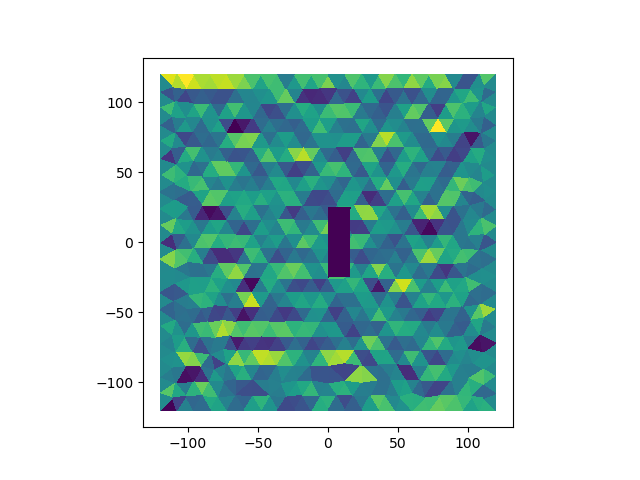

[[ 1.13906044e-02  8.23733443e-15  1.36687253e+02]
 [ 1.35812523e-02 -6.19296281e-16  1.62975027e+02]
 [ 1.30104941e-02  5.20156834e-14  1.56125929e+02]
 ...
 [ 7.18265377e-03 -1.61407346e-14  8.61918452e+01]
 [ 7.65426256e-03 -1.69809913e-14  9.18511507e+01]
 [ 7.85554241e-03  2.61075883e-15  9.42665089e+01]]


In [4]:
import matplotlib.pyplot as plt
%matplotlib widget 

fig, ax = plt.subplots()
ax.tripcolor(meshes[1].coords[:, 0], meshes[1].coords[:, 1], meshes[1].verts, meshes[1].normal_vector[:, 1])
ax.tripcolor(meshes[0].coords[:, 0], meshes[0].coords[:, 1], meshes[0].verts, meshes[0].normal_vector[:, 2])
ax.set_aspect("equal")
plt.show()
print(meshes[1].normal_vector)

# Set up inversion of Relax displacements

## Matrix assembly

In [5]:
# Get triangular smoothing matrix

operators = addict.Dict()
celeri.get_all_mesh_smoothing_matrices_simple(meshes, operators)

# Assemble matrices
assembled_mat = np.zeros((np.size(obsg)+3*ntri, 3*ntri))
# Insert elastic partials
assembled_mat[0:np.size(obsg), :] = disp_mat.reshape((-1, 3*ntri))
# Insert smoothing matrices
source_row_start = np.size(obsg)
source_row_end = np.size(obsg) + 3*nsource_tri
assembled_mat[source_row_start:source_row_end, 0:3*nsource_tri] = operators.smoothing_matrix[0].toarray()
assembled_mat[source_row_end:, 3*nsource_tri:] = operators.smoothing_matrix[1].toarray()

# Assemble weighting vector
smoothing_weight = 1e-3
weights = np.ones((np.shape(assembled_mat)[0], 1))
weights[source_row_start:] = smoothing_weight

## Sequential reading and inversion of modified displacement grids

- Read each time step's displacement grid
- Add cumulative interseismic displacement: backslip rate times elapsed time since earthquake
   - `backslip_rate = 0.001` yields maximum source slip of 0.02, similar to maximum horizon slip. Basal slip estimate looks similar to inversion of unmodified displacements.
   - `backslip_rate = 0.01` yields maximum source slip of 0.2, 10x maximum horizon slip. Basal slip estimate looks similar to inversion of unmodified displacements.
   - `backslip_rate = 0.1` yields maximum source slip of 2, 100x maximum horizon slip. Basal slip estimate looks different from inversion of unmodified displacements: faster slip, more equant concentration (less elongation parallel to strike), more checkerboarding (positive dip-slip surrounded by negative halo). The deviation from the unperturbed displacement estimation begins about half-way through the time sequence. *Need to plot predicted displacements from basal slip only vs. Relax displacements.*
   

In [23]:
import glob


# Read sequence of displacement grd files and invert
e_disp_file_list = sorted(glob.glob(directory + "/*-relax-east.grd"))
n_disp_file_list = sorted(glob.glob(directory + "/*-relax-north.grd"))
u_disp_file_list = sorted(glob.glob(directory + "/*-relax-up.grd"))

# Read time vector
time_vector = np.loadtxt(directory + "/time.txt", unpack=False)

# Selected times, expressed in postseismic years
sel_times = np.array([1, 10, 20])
n_times = len(sel_times)

# Determine index of selected times
sel_times_idx = np.nonzero(np.isin(time_vector, sel_times))[0]

# Unit displacement field
backslip_vec = np.array([[0, -1, 0], [0, -1, 0]])
# Partials from first two elements (source). This gives displacements due to unit source slip 
unit_inter_disp = disp_mat[:, :, 0:2, :].reshape((-1, 6)).dot(backslip_vec.flatten())

# Define backslip rate 
# Backslip rate is positive, but when multiplied by backslip vector gives normal slip (slip deficit) in cutde
# Rate guidance:
# 0.005 = 1 unit in 200 years
# 0.01 = 1 unit in 100 years
# 0.02 = 1 unit in 50 years
# 0.05 = 1 unit in 20 years
# 0.1 = 1 unit in 10 years
backslip_rate = 0.1

# Allocate space for estimated slip and predicted displacements
est_slip = np.zeros((3*ntri, n_times))
pred_disp = np.zeros((obsg_full.size, n_times))
pred_disp_source = np.zeros((obsg_full.size, n_times))
pred_disp_horiz = np.zeros((obsg_full.size, n_times))

# Allocate space for data vector
data_vector = np.zeros(source_row_start+3*ntri)

# Create a pseudorandom vector to add noise to displacements
# One column for each time step 
rng = np.random.default_rng(54325)
noise_mag = backslip_rate/10
e_noise_full = rng.normal(0, noise_mag, size=(obsg_full.shape[0], len(e_disp_file_list)))
n_noise_full = rng.normal(0, noise_mag, size=(obsg_full.shape[0], len(e_disp_file_list)))
u_noise_full = rng.normal(0, noise_mag, size=(obsg_full.shape[0], len(e_disp_file_list)))

# Calculate model covariance
cov = np.linalg.inv(assembled_mat.T * weights.T @ assembled_mat) 

# Read each file and invert 
for i in range(n_times):
    # Read components
    e_disp = xa.load_dataarray(e_disp_file_list[sel_times_idx[i]])
    n_disp = xa.load_dataarray(n_disp_file_list[sel_times_idx[i]])
    u_disp = xa.load_dataarray(u_disp_file_list[sel_times_idx[i]])
    # Take the same subset as when setting up partials
    disp_array = np.array([e_disp[0::gsubset, 0::gsubset], n_disp[0::gsubset, 0::gsubset], u_disp[0::gsubset, 0::gsubset]]).reshape((3, -1)).T.copy()
    noise_array = np.array((e_noise_full[li, i], n_noise_full[li, i], u_noise_full[li, i])).T
    data_vector[0:source_row_start] = disp_array.flatten() + noise_array.flatten() + backslip_rate*sel_times[i]*unit_inter_disp 
    # Estimate slip using pre-calculated covariance
    est_slip[:, i] = cov @ assembled_mat.T * weights.T @ data_vector 
    # Predict displacement at the full grid resolution
    pred_disp[:, i] = disp_mat_full.reshape((-1, 3*ntri)).dot(est_slip[:, i])
    # Predict displacement from source slip
    pred_disp_source[:, i] = disp_mat_full[:, :, 0:nsource_tri, :].reshape((-1, 3*nsource_tri)).dot(est_slip[0:3*nsource_tri, i])
    # Predict displacement from basal horizon slip
    pred_disp_horiz[:, i] = disp_mat_full[:, :, nsource_tri:, :].reshape((-1, 3*nhoriz_tri)).dot(est_slip[3*nsource_tri:, i])


### Using subsets of stations for estimation 

In [ ]:
# Fixed random seed for reproducibility
full_seed = np.random.default_rng(10)
# Random station index
n_subset = 100
latp = 1 - np.abs(obsg[:, 1])/100
latp = latp/np.sum(latp)
rsubset = np.sort(full_seed.choice(len(disp_array), n_subset, replace=False, p=latp))

zero_x_index = np.where(obsg[:, 0] >= 0)[0]
latp_h = 1 - np.abs(obsg[zero_x_index, 1])/100
latp_h = latp_h/np.sum(latp_h)
# Random station index, hanging wall only
rsubset_h = np.sort(full_seed.choice(zero_x_index, n_subset, replace=False, p=latp_h))

# Three-component indices
rsubset_idx3 = celeri.get_3component_index(rsubset)
rsubset_h_idx3 = celeri.get_3component_index(rsubset_h)

100
100


In [9]:
# Extract assembled matrix subset and calculate covariance
assembled_mat_rsubset = np.vstack((assembled_mat[rsubset_idx3, :], assembled_mat[source_row_start:, :]))
assembled_mat_rsubset_h = np.vstack((assembled_mat[rsubset_h_idx3, :], assembled_mat[source_row_start:, :]))

# Can use the same weights for both subsets, because they're all 1 for the displacements
weights_rsubset = np.vstack((weights[rsubset_idx3, :], weights[source_row_start:, :]))

# Calculate model covariance
cov_rsubset = np.linalg.inv(assembled_mat_rsubset.T * weights_rsubset.T @ assembled_mat_rsubset) 
cov_rsubset_h = np.linalg.inv(assembled_mat_rsubset_h.T * weights_rsubset.T @ assembled_mat_rsubset_h) 

# Allocate space for estimated slip and predicted displacements
est_slip_rsubset = np.zeros((3*ntri, n_times))
pred_disp_rsubset = np.zeros((obsg_full.size, n_times))
pred_disp_source_rsubset = np.zeros((obsg_full.size, n_times))
pred_disp_horiz_rsubset = np.zeros((obsg_full.size, n_times))

est_slip_rsubset_h = np.zeros((3*ntri, n_times))
pred_disp_rsubset_h = np.zeros((obsg_full.size, n_times))
pred_disp_source_rsubset_h = np.zeros((obsg_full.size, n_times))
pred_disp_horiz_rsubset_h = np.zeros((obsg_full.size, n_times))

# Allocate space for data vector
data_vector_rsubset = np.zeros(3*n_subset+3*ntri)
data_vector_rsubset_h = np.zeros(3*n_subset+3*ntri)

# Read each file and invert 
for i in range(n_times):
    # Read components. Negated because rake was set to -90 (normal), rather than 90 (reverse)
    e_disp = xa.load_dataarray(e_disp_file_list[sel_times_idx[i]])
    n_disp = xa.load_dataarray(n_disp_file_list[sel_times_idx[i]])
    u_disp = xa.load_dataarray(u_disp_file_list[sel_times_idx[i]])
    # Take the same subset as when setting up partials
    disp_array = np.array([e_disp[0::gsubset, 0::gsubset], n_disp[0::gsubset, 0::gsubset], u_disp[0::gsubset, 0::gsubset]]).reshape((3, -1)).T.copy()
    noise_array = np.array((e_noise_full[li, i], n_noise_full[li, i], u_noise_full[li, i])).T
    # Take subsets of displacement and noise arrays
    disp_array_rsubset = disp_array[rsubset, :]
    noise_array_rsubset = noise_array[rsubset, :]
    disp_array_rsubset_h = disp_array[rsubset_h, :]
    noise_array_rsubset_h = noise_array[rsubset_h, :]
    
    # Arrange into vector
    data_vector_rsubset[0:3*n_subset] = disp_array_rsubset.flatten() + noise_array_rsubset.flatten() + backslip_rate*sel_times[i]*unit_inter_disp[rsubset_idx3]
    data_vector_rsubset_h[0:3*n_subset] = disp_array_rsubset_h.flatten() + noise_array_rsubset_h.flatten() + backslip_rate*sel_times[i]*unit_inter_disp[rsubset_h_idx3]

    # Estimate slip using pre-calculated covariance
    est_slip_rsubset[:, i] = cov_rsubset @ assembled_mat_rsubset.T * weights_rsubset.T @ data_vector_rsubset 
    est_slip_rsubset_h[:, i] = cov_rsubset_h @ assembled_mat_rsubset_h.T * weights_rsubset.T @ data_vector_rsubset_h
    # Predict displacement at the full grid resolution
    pred_disp_rsubset[:, i] = disp_mat_full.reshape((-1, 3*ntri)).dot(est_slip_rsubset[:, i])
    pred_disp_rsubset_h[:, i] = disp_mat_full.reshape((-1, 3*ntri)).dot(est_slip_rsubset_h[:, i])
    # Predict displacement from source slip
    pred_disp_source_rsubset[:, i] = disp_mat_full[:, :, 0:nsource_tri, :].reshape((-1, 3*nsource_tri)).dot(est_slip_rsubset[0:3*nsource_tri, i])
    pred_disp_source_rsubset_h[:, i] = disp_mat_full[:, :, 0:nsource_tri, :].reshape((-1, 3*nsource_tri)).dot(est_slip_rsubset_h[0:3*nsource_tri, i])
    # Predict displacement from basal horizon slip
    pred_disp_horiz_rsubset[:, i] = disp_mat_full[:, :, nsource_tri:, :].reshape((-1, 3*nhoriz_tri)).dot(est_slip_rsubset[3*nsource_tri:, i])
    pred_disp_horiz_rsubset_h[:, i] = disp_mat_full[:, :, nsource_tri:, :].reshape((-1, 3*nhoriz_tri)).dot(est_slip_rsubset_h[3*nsource_tri:, i])

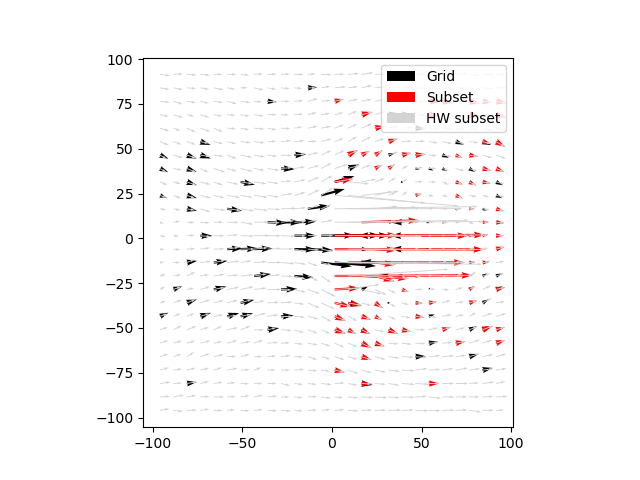

In [10]:
# Plot displacements: regular grid, whole region subset, and hanging wall subset 
fig, ax = plt.subplots()
ax.quiver(obsg[rsubset, 0], obsg[rsubset, 1], disp_array_rsubset[:, 0], disp_array_rsubset[:, 1], color='k', scale=1, label="Grid")
inter_disp_rsubset = unit_inter_disp[rsubset_idx3]

ax.quiver(obsg[rsubset_h, 0], obsg[rsubset_h, 1], data_vector_rsubset_h[0:3*n_subset:3], data_vector_rsubset_h[1:3*n_subset:3], color='r', scale=1, label="Subset")
ax.quiver(obsg[:, 0], obsg[:, 1], data_vector[0:source_row_start:3], data_vector[1:source_row_start:3], color='lightgray', scale=1, label="HW subset")

ax.set_aspect("equal")
ax.legend()
plt.show()

## Plot results

### Displacement grids (east component)

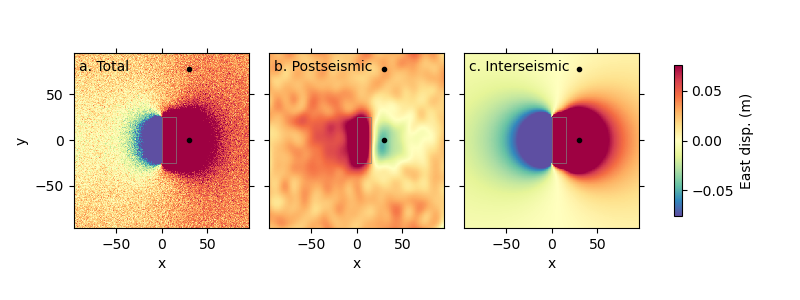

In [24]:
# Make a time series array for all east displacements
e_disp_array = np.zeros((np.shape(obsg_full)[0], len(e_disp_file_list)))
n_disp_array = np.zeros((np.shape(obsg_full)[0], len(n_disp_file_list)))
u_disp_array = np.zeros((np.shape(obsg_full)[0], len(u_disp_file_list)))

# Displacement field from backslip on source
unit_inter_disp_full = disp_mat_full[:, :, 0:2, :].reshape((-1, 6)).dot(backslip_vec.flatten())

# For all time steps,
for i in range(len(e_disp_file_list)):
    # Read in Relax displacements
    e_disp = xa.load_dataarray(e_disp_file_list[i])
    n_disp = xa.load_dataarray(n_disp_file_list[i])
    u_disp = xa.load_dataarray(u_disp_file_list[i])
    # Add to an array for later displacement vs. time plot
    disp_from_backslip = backslip_rate*time_vector[i]*unit_inter_disp_full
    e_disp_array[:, i] = np.array(e_disp).flatten() + disp_from_backslip[0::3] + e_noise_full[:, i]
    n_disp_array[:, i] = np.array(n_disp).flatten() + disp_from_backslip[1::3] + n_noise_full[:, i]
    u_disp_array[:, i] = np.array(u_disp).flatten() + disp_from_backslip[2::3] + u_noise_full[:, i]

# pyplot figure: 3 panels, total, CMI postseismic, and interseismic displacements
fig, ax = plt.subplots(1, 3, figsize=(8, 3))
# Set up axis and color limits
x_limits = np.array([np.min(xg), np.max(xg)])
y_limits = np.array([np.min(yg), np.max(yg)])
d_min = -0.076
d_max = 0.076

# Source fault outline coordinates
sfo_x = np.array([0, 17*np.cos(np.deg2rad(20)), 17*np.cos(np.deg2rad(20)), 0, 0])
sfo_y = 25*np.array([-1, -1, 1, 1, -1])

# Get target coordinates
c1 = [30, 0]
c2 = [30, 78]

cmap_name="Spectral_r"
# for i in range(len(sel_times)):
i = 2 # Just focusing on time = 20 years
# Total (noisy) displacement
ax[0].pcolormesh(Xg, Yg, e_disp_array[:, sel_times_idx[i]].reshape(np.shape(Xg)), vmin=d_min, vmax=d_max, cmap=cmap_name)
ax[0].plot(sfo_x, sfo_y, color='gray', linewidth=0.5)
ax[0].plot((c1[0], c2[0]), (c1[1], c2[1]), '.k')
# # Estimated CMI slip
# ax[1].tripcolor(meshes[0].coords[:, 0], meshes[0].coords[:, 1], meshes[0].verts, facecolors=est_slip[1::3, i], vmin=d_min, vmax=d_max, cmap=cmap_name)
# ax[1].plot(sfo_x, sfo_y, color='gray', linewidth=0.5)
# # Predicted displacement from CMI slip
co = ax[1].pcolormesh(Xg, Yg, pred_disp_horiz[0::3, i].reshape(np.shape(Xg)), vmin=d_min, vmax=d_max, cmap=cmap_name)
# plt.colorbar(co, location='bottom')
ax[1].plot(sfo_x, sfo_y, color='gray', linewidth=0.5)
ax[1].plot((c1[0], c2[0]), (c1[1], c2[1]), '.k')
# Predicted displacement from source slip deficit 
ax[2].pcolormesh(Xg, Yg, pred_disp_source[0::3, i].reshape(np.shape(Xg)), vmin=d_min, vmax=d_max, cmap=cmap_name)
ax[2].plot(sfo_x, sfo_y, color='gray', linewidth=0.5)
ax[2].plot((c1[0], c2[0]), (c1[1], c2[1]), '.k')

plt.setp(ax, xlim=x_limits, ylim=y_limits, aspect="equal", xlabel="x")
ax[0].tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False, bottom=True, top=True, left=True, right=True)
ax[1].tick_params(labelbottom=True, labeltop=False, labelleft=False, labelright=False, bottom=True, top=True, left=True, right=True)
ax[2].tick_params(labelbottom=True, labeltop=False, labelleft=False, labelright=False, bottom=True, top=True, left=True, right=True)

ax[0].set_ylabel("y")
# ax[2].set_ylabel("y")
# ax[2].yaxis.set_label_position("right")

ax[0].text(-90, 75, "a. Total")
ax[1].text(-90, 75, "b. Postseismic")
ax[2].text(-90, 75, "c. Interseismic")

plt.tight_layout()
fig.colorbar(co, ax=ax.ravel().tolist(), label="East disp. (m)", shrink=0.6)
figname = "total_post_inter_map0_%02drate" %(backslip_rate*100)
plt.savefig(figname + ".pdf")
plt.savefig(figname + ".png")
plt.show()



### Subset displacement maps

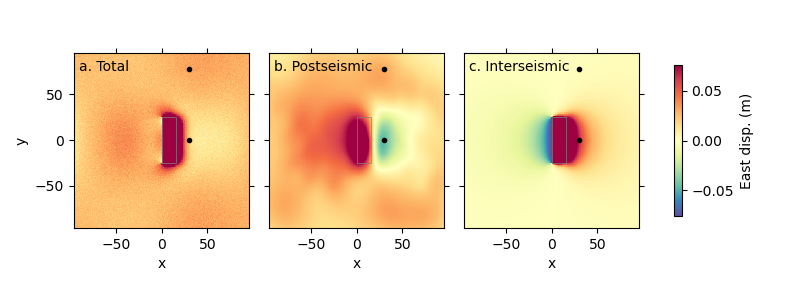

In [13]:
# pyplot figure: 3 panels, total, CMI postseismic, and interseismic displacements
fig, ax = plt.subplots(1, 3, figsize=(8, 3))

# for i in range(len(sel_times)):
i = 2 # Just focusing on time = 20 years
# Total (noisy) displacement
ax[0].pcolormesh(Xg, Yg, e_disp_array[:, sel_times_idx[i]].reshape(np.shape(Xg)), vmin=d_min, vmax=d_max, cmap=cmap_name)
ax[0].plot(sfo_x, sfo_y, color='gray', linewidth=0.5)
ax[0].plot((c1[0], c2[0]), (c1[1], c2[1]), '.k')
# # Estimated CMI slip
# ax[1].tripcolor(meshes[0].coords[:, 0], meshes[0].coords[:, 1], meshes[0].verts, facecolors=est_slip[1::3, i], vmin=d_min, vmax=d_max, cmap=cmap_name)
# ax[1].plot(sfo_x, sfo_y, color='gray', linewidth=0.5)
# # Predicted displacement from CMI slip
co = ax[1].pcolormesh(Xg, Yg, pred_disp_horiz_rsubset[0::3, i].reshape(np.shape(Xg)), vmin=d_min, vmax=d_max, cmap=cmap_name)
# plt.colorbar(co, location='bottom')
ax[1].plot(sfo_x, sfo_y, color='gray', linewidth=0.5)
ax[1].plot((c1[0], c2[0]), (c1[1], c2[1]), '.k')
# Predicted displacement from source slip deficit 
ax[2].pcolormesh(Xg, Yg, pred_disp_source_rsubset[0::3, i].reshape(np.shape(Xg)), vmin=d_min, vmax=d_max, cmap=cmap_name)
ax[2].plot(sfo_x, sfo_y, color='gray', linewidth=0.5)
ax[2].plot((c1[0], c2[0]), (c1[1], c2[1]), '.k')

plt.setp(ax, xlim=x_limits, ylim=y_limits, aspect="equal", xlabel="x")
ax[0].tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False, bottom=True, top=True, left=True, right=True)
ax[1].tick_params(labelbottom=True, labeltop=False, labelleft=False, labelright=False, bottom=True, top=True, left=True, right=True)
ax[2].tick_params(labelbottom=True, labeltop=False, labelleft=False, labelright=False, bottom=True, top=True, left=True, right=True)

ax[0].set_ylabel("y")
# ax[2].set_ylabel("y")
# ax[2].yaxis.set_label_position("right")

ax[0].text(-90, 75, "a. Total")
ax[1].text(-90, 75, "b. Postseismic")
ax[2].text(-90, 75, "c. Interseismic")

plt.tight_layout()
fig.colorbar(co, ax=ax.ravel().tolist(), label="East disp. (m)", shrink=0.6)


### Displacement vs. time at selected points

-0.027032110624877995
0.12519721574625794
-0.08485354037125568
0.03374085626335499
-0.014936127783364438
-0.018460468208776705


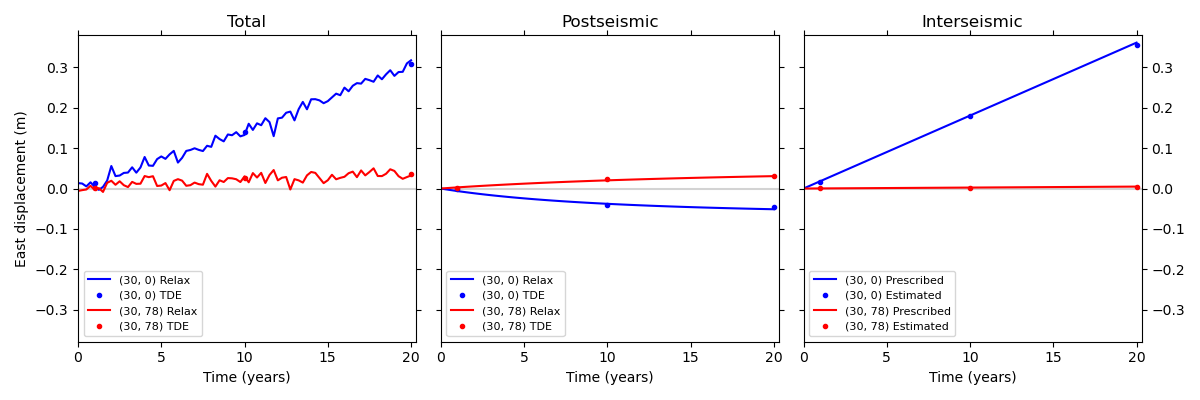

In [25]:
%matplotlib widget

# Coordinate indices
grididx1 = np.where((obsg_full[:, 0]==c1[0]) & (obsg_full[:, 1]==c1[1]))[0]
grididx2 = np.where((obsg_full[:, 0]==c2[0]) & (obsg_full[:, 1]==c2[1]))[0]

# TOTAL observed and predicted displacements
tobsdisp1 = e_disp_array[grididx1, :]
tobsdisp2 = e_disp_array[grididx2, :]
tpreddisp1 = pred_disp[3*grididx1, :]
tpreddisp2 = pred_disp[3*grididx2, :]
print((tpreddisp1[0, -1]-tobsdisp1[0, -1])/tobsdisp1[0, -1])
print((tpreddisp2[0, -1]-tobsdisp2[0, -1])/tobsdisp2[0, -1])

# Find element centroid nearest target coordinates
horiz_centroids = np.mean(horiz_tri_pts, axis=1)
dist1 = np.sqrt((horiz_centroids[:, 0] - c1[0])**2 + (horiz_centroids[:, 1] - c1[1])**2)
dist2 = np.sqrt((horiz_centroids[:, 0] - c2[0])**2 + (horiz_centroids[:, 1] - c2[1])**2)
el_idx1 = np.argmin(dist1)
el_idx2 = np.argmin(dist2)
slip1 = est_slip[3*(nsource_tri+el_idx1)+1, :]
slip2 = est_slip[3*(nsource_tri+el_idx2)+1, :]

# Set up figure
lfs=8 # Legend font size
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, figsize=(12, 4))
ax1.hlines(0, xmin=-1, xmax=21, color='lightgray')
ax1.plot(time_vector, tobsdisp1[0, :], 'b', label="(30, 0) Relax")
ax1.plot(time_vector[sel_times_idx], tpreddisp1[0, :], 'b.', label="(30, 0) TDE")
ax1.plot(time_vector, tobsdisp2[0, :], 'r', label="(30, 78) Relax")
ax1.plot(time_vector[sel_times_idx], tpreddisp2[0, :], 'r.', label="(30, 78) TDE")
ax1.legend(fontsize=lfs, loc='lower left')
ax1.set_xlabel('Time (years)')
ax1.set_ylabel('East displacement (m)')
ax1.set_title("Total")
# axr = ax1.twinx()
# axr.plot(time_vector, slip1, 'b--', linewidth=3)
# axr.plot(time_vector, slip2, 'r--', linewidth=3)
# axr.set_ylabel('Dip-slip')

# fig.savefig(f"png/timeseries.png")


#
# Basal displacements only
#
# Observed and predicted displacements
bobsdisp1 = e_disp_array[grididx1, :] - backslip_rate*time_vector*unit_inter_disp_full[3*grididx1] - e_noise_full[grididx1, :]
bobsdisp2 = e_disp_array[grididx2, :] - backslip_rate*time_vector*unit_inter_disp_full[3*grididx2] - e_noise_full[grididx2, :]
bpreddisp1 = pred_disp_horiz[3*grididx1, :]
bpreddisp2 = pred_disp_horiz[3*grididx2, :]
print((bpreddisp1[0, -1]-bobsdisp1[0, -1])/bobsdisp1[0, -1])
print((bpreddisp2[0, -1]-bobsdisp2[0, -1])/bobsdisp2[0, -1])
ax2.hlines(0, xmin=-1, xmax=21, color='lightgray')
ax2.plot(time_vector, bobsdisp1[0, :], 'b', label="(30, 0) Relax")
ax2.plot(time_vector[sel_times_idx], bpreddisp1[0, :], 'b.', label="(30, 0) TDE")
ax2.plot(time_vector, bobsdisp2[0, :], 'r', label="(30, 78) Relax")
ax2.plot(time_vector[sel_times_idx], bpreddisp2[0, :], 'r.', label="(30, 78) TDE")
ax2.legend(fontsize=lfs, loc='lower left')
ax2.set_xlabel('Time (years)')
# ax2.set_ylabel('East displacement')
ax2.set_title("Postseismic")


#
# Source displacements only
#
# Observed and predicted displacements
sobsdisp1 = backslip_rate*time_vector*unit_inter_disp_full[3*grididx1]
sobsdisp2 = backslip_rate*time_vector*unit_inter_disp_full[3*grididx2]
spreddisp1 = pred_disp_source[3*grididx1, :]
spreddisp2 = pred_disp_source[3*grididx2, :]
print((spreddisp1[0, -1]-sobsdisp1[-1])/sobsdisp1[-1])
print((spreddisp2[0, -1]-sobsdisp2[-1])/sobsdisp2[-1])
ax3.hlines(0, xmin=-1, xmax=21, color='lightgray')
ax3.plot(time_vector, sobsdisp1, 'b', label="(30, 0) Prescribed")
ax3.plot(time_vector[sel_times_idx], spreddisp1[0, :], 'b.', label="(30, 0) Estimated")
ax3.plot(time_vector, sobsdisp2, 'r', label="(30, 78) Prescribed")
ax3.plot(time_vector[sel_times_idx], spreddisp2[0, :], 'r.', label="(30, 78) Estimated")
ax3.legend(fontsize=lfs, loc='lower left')
ax3.set_xlabel('Time (years)')

ax3.set_title("Interseismic")

# Compile y-axis limits to find right range
ylims = np.max(np.abs(np.array((ax1.get_ylim(), ax2.get_ylim(), ax3.get_ylim()))))
plt.setp((ax1, ax2, ax3), xlim=(0, 20.3), ylim=(-ylims, ylims))

# Adjust axis labeling
ax1.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False, bottom=True, top=True, left=True, right=True)
ax2.tick_params(labelbottom=True, labeltop=False, labelleft=False, labelright=False, bottom=True, top=True, left=True, right=True)
ax3.tick_params(labelbottom=True, labeltop=False, labelleft=False, labelright=True, bottom=True, top=True, left=True, right=True)
# ax3.set_ylabel('East displacement')
# ax3.yaxis.set_label_position("right")

plt.tight_layout()
figname = "post_inter0_%02drate" %(backslip_rate*100)
plt.savefig(figname  + ".pdf")
plt.savefig(figname  + ".png")
plt.show()

### Subset time series plots

[[30. 78.  0.]]


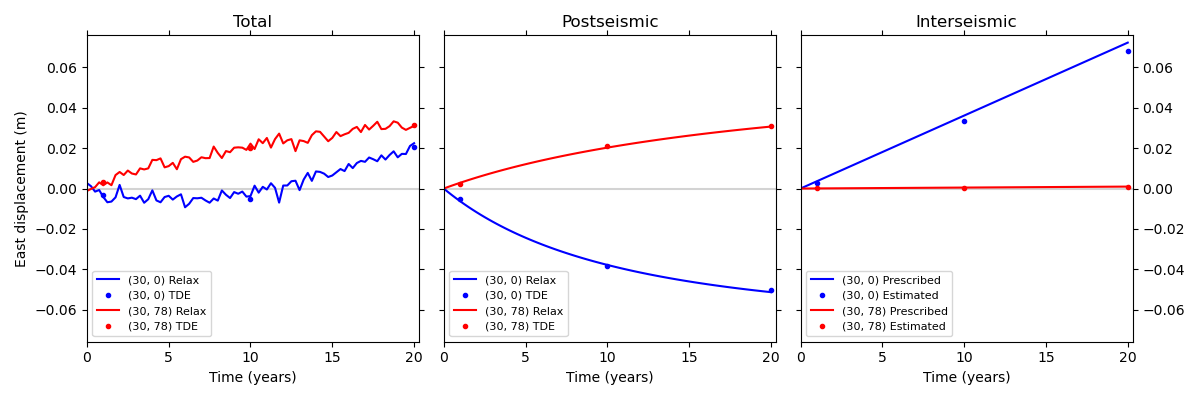

In [ ]:
# TOTAL observed and predicted displacements
tobsdisp1 = e_disp_array[grididx1, :]
tobsdisp2 = e_disp_array[grididx2, :]
tpreddisp1_rsubset = pred_disp_rsubset[3*grididx1, :]
tpreddisp2_rsubset = pred_disp_rsubset[3*grididx2, :]

# Find element centroid nearest target coordinates
horiz_centroids = np.mean(horiz_tri_pts, axis=1)
dist1 = np.sqrt((horiz_centroids[:, 0] - c1[0])**2 + (horiz_centroids[:, 1] - c1[1])**2)
dist2 = np.sqrt((horiz_centroids[:, 0] - c2[0])**2 + (horiz_centroids[:, 1] - c2[1])**2)
el_idx1 = np.argmin(dist1)
el_idx2 = np.argmin(dist2)
slip1 = est_slip[3*(nsource_tri+el_idx1)+1, :]
slip2 = est_slip[3*(nsource_tri+el_idx2)+1, :]

# Set up figure
lfs=8 # Legend font size
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, figsize=(12, 4))
ax1.hlines(0, xmin=-1, xmax=21, color='lightgray')
ax1.plot(time_vector, tobsdisp1[0, :], 'b', label="(30, 0) Relax")
ax1.plot(time_vector[sel_times_idx], tpreddisp1_rsubset[0, :], 'b.', label="(30, 0) TDE")
ax1.plot(time_vector, tobsdisp2[0, :], 'r', label="(30, 78) Relax")
ax1.plot(time_vector[sel_times_idx], tpreddisp2_rsubset[0, :], 'r.', label="(30, 78) TDE")
ax1.legend(fontsize=lfs, loc='lower left')
ax1.set_xlabel('Time (years)')
ax1.set_ylabel('East displacement (m)')
ax1.set_title("Total")
# axr = ax1.twinx()
# axr.plot(time_vector, slip1, 'b--', linewidth=3)
# axr.plot(time_vector, slip2, 'r--', linewidth=3)
# axr.set_ylabel('Dip-slip')

# fig.savefig(f"png/timeseries.png")


#
# Basal displacements only
#
# Observed and predicted displacements
bobsdisp1 = e_disp_array[grididx1, :] - backslip_rate*time_vector*unit_inter_disp_full[3*grididx1] - e_noise_full[grididx1, :]
bobsdisp2 = e_disp_array[grididx2, :] - backslip_rate*time_vector*unit_inter_disp_full[3*grididx2] - e_noise_full[grididx2, :]
bpreddisp1_rsubset = pred_disp_horiz_rsubset[3*grididx1, :]
bpreddisp2_rsubset = pred_disp_horiz_rsubset[3*grididx2, :]
ax2.hlines(0, xmin=-1, xmax=21, color='lightgray')
ax2.plot(time_vector, bobsdisp1[0, :], 'b', label="(30, 0) Relax")
ax2.plot(time_vector[sel_times_idx], bpreddisp1[0, :], 'b.', label="(30, 0) TDE")
ax2.plot(time_vector, bobsdisp2[0, :], 'r', label="(30, 78) Relax")
ax2.plot(time_vector[sel_times_idx], bpreddisp2[0, :], 'r.', label="(30, 78) TDE")
ax2.legend(fontsize=lfs, loc='lower left')
ax2.set_xlabel('Time (years)')
# ax2.set_ylabel('East displacement')
ax2.set_title("Postseismic")


#
# Source displacements only
#
# Observed and predicted displacements
sobsdisp1 = backslip_rate*time_vector*unit_inter_disp_full[3*grididx1]
sobsdisp2 = backslip_rate*time_vector*unit_inter_disp_full[3*grididx2]
spreddisp1_rsubset = pred_disp_source_rsubset[3*grididx1, :]
spreddisp2_rsubset = pred_disp_source_rsubset[3*grididx2, :]
ax3.hlines(0, xmin=-1, xmax=21, color='lightgray')
ax3.plot(time_vector, sobsdisp1, 'b', label="(30, 0) Prescribed")
ax3.plot(time_vector[sel_times_idx], spreddisp1_rsubset[0, :], 'b.', label="(30, 0) Estimated")
ax3.plot(time_vector, sobsdisp2, 'r', label="(30, 78) Prescribed")
ax3.plot(time_vector[sel_times_idx], spreddisp2_rsubset[0, :], 'r.', label="(30, 78) Estimated")
ax3.legend(fontsize=lfs, loc='lower left')
ax3.set_xlabel('Time (years)')

ax3.set_title("Interseismic")

# Compile y-axis limits to find right range
ylims = np.max(np.abs(np.array((ax1.get_ylim(), ax2.get_ylim(), ax3.get_ylim()))))
plt.setp((ax1, ax2, ax3), xlim=(0, 20.3), ylim=(-ylims, ylims))

# Adjust axis labeling
ax1.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False, bottom=True, top=True, left=True, right=True)
ax2.tick_params(labelbottom=True, labeltop=False, labelleft=False, labelright=False, bottom=True, top=True, left=True, right=True)
ax3.tick_params(labelbottom=True, labeltop=False, labelleft=False, labelright=True, bottom=True, top=True, left=True, right=True)
# ax3.set_ylabel('East displacement')
# ax3.yaxis.set_label_position("right")

plt.tight_layout()

plt.show()



### Prescribed vs. estimated source slip rate

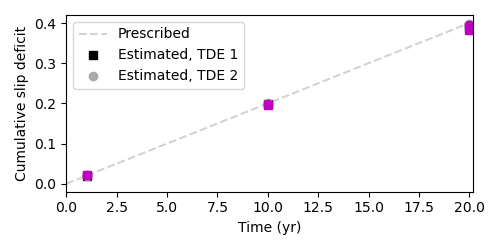

[0.02 0.2  0.4 ]
[0.01829919 0.1971851  0.39160129]
[0.02018296 0.19996124 0.39724734]


In [18]:
fig, ax = plt.subplots(figsize=(5, 2.5))
ax.plot(time_vector, backslip_rate*time_vector, '--', color='lightgray', label='Prescribed')
ax.plot(time_vector[sel_times_idx], -est_slip[1, :], 'sk', label="Estimated, TDE 1")
ax.plot(time_vector[sel_times_idx], -est_slip[4, :], 'o', color="darkgray", label="Estimated, TDE 2")
ax.plot(time_vector[sel_times_idx], -est_slip_rsubset[1, :], 'sm')
ax.plot(time_vector[sel_times_idx], -est_slip_rsubset[4, :], 'om')
ax.set_xlim((0, 20.2))
ax.set_xlabel("Time (yr)")
ax.set_ylabel("Cumulative slip deficit")
plt.legend()
plt.tight_layout()
plt.show()
print(backslip_rate*time_vector[sel_times_idx])
print(-est_slip[1, :])
print(-est_slip[4, :])